#  Detección de Phishing

In [3]:
#Importar las librerías
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Parte 1: Ingeniería de características

In [4]:
## Cargar el dataset proporcionado
df = pd.read_csv('dataset_pishing.csv')
print(df.shape)

#Ejemplos de dominios phishing
df[df.status == 'phishing'].sample(5)

(11430, 2)


,url,status
6217,http://www.poolscalifornia.top/Login_step_2.html,phishing
6805,https://fairilyused.com/wp-content/upgrade/en/...,phishing
7226,http://fast-joingroup1.itsaol.com/,phishing
163,http://www.instohelp.com/assets_flight/libs/bo...,phishing
7470,https://lhodgebuk.com/en/index.html,phishing


In [5]:
#Ejemplos de dominios legitimos
df[df.status == 'legitimate'].sample(5)

,url,status
6004,https://www.wyzant.com/resources/lessons/math/...,legitimate
1409,https://www.vocabulary.com/dictionary/DNA,legitimate
936,http://www.guru99.com/database-design.html,legitimate
9859,https://www.direct-energie.com/,legitimate
9468,https://commons.wikimedia.org/wiki/Category:Pu...,legitimate


In [6]:
# Contar la cantidad de observaciones para cada etiqueta en la columna 'status'
conteo_status = df['status'].value_counts()

# Mostrar los resultados
print("Cantidad de observaciones etiquetadas como 'legitimate':", conteo_status['legitimate'])
print("Cantidad de observaciones etiquetadas como 'phishing':", conteo_status['phishing'])

Cantidad de observaciones etiquetadas como 'legitimate': 5715
Cantidad de observaciones etiquetadas como 'phishing': 5715


R// Sí está balanceado el dataset

### Derivación de características

1. **¿Qué ventajas tiene el análisis de una URL contra el análisis de otros datos, cómo el tiempo de vida del dominio, o las características de la página Web?**

- El análisis de una URL ofrece un mayor acercamiento a un sitio web específico en comparación con otros análisis, ya que una URL es un recurso único y propio del sitio evaluado, lo que regularmente proporciona información sobre el mismo sin necesidad de acceder a él directamente. Además de la longitud de la URL y la presencia de caracteres sospechosos, el análisis puede revelar subdominios inusuales, la falta de protocolos o cifrados como HTTPS, errores gramaticales u ortográficos y otras características que permiten evaluar si un sitio web es potencialmente peligroso. Además, el análisis de URL permite identificar la ubicación geográfica del servidor, lo que puede ayudar a los usuarios a determinar si el sitio web proviene de una región conocida por prácticas cibernéticas sospechosas. También es posible analizar la fecha de creación y caducidad de la URL, lo que proporciona información sobre la antigüedad del sitio y su posible legitimidad. Además, al analizar la URL, se pueden detectar posibles redirecciones no deseadas, lo que ayuda a prevenir ataques de phishing y otros tipos de fraude en línea. En resumen, el análisis de URL es una herramienta poderosa para evaluar la seguridad y confiabilidad de un sitio web antes de interactuar con él.

2. **¿Qué características de una URL son más prometedoras para la detección de phishing?**

- Longitud de la URL (URL acortadas).
- Conteo de subdominios.
- Dominios aleatorios.
- Cantidad de vocales o consonantes.
- Entropía de símbolos.
- Puerto, ip y HTTPS tokens.
- Cantidad de redirecciones.
- Extensiones del path.
- Uso de caracteres especiales
- Uso de guíones y guíones bajos.
- Longitud de nombre del dominio.
- Palabras claves sensibles.
- Coincidencia con marcas conocidas.
- Tiempo de vida del dominio.
- Uso de dominios de nivel superior sospechosos.
- Presencia de cadenas numéricas aleatorias.

### Funciones

In [9]:
from urllib.parse import urlparse
from datetime import datetime
import requests
import re
import whois
import socket

def url_length(url):
    return len(url)

def subdomain_count(url):
    parsed_url = urlparse(url)
    return len(parsed_url.netloc.split('.')) - 2  # subtracting 2 for domain and top-level domain

def vowel_consonant_ratio (x):
    # Calculate vowel to consonant ratio
    x = x.lower()
    vowels_pattern = re.compile('([aeiou])')
    consonants_pattern = re.compile('([b-df-hj-np-tv-z])')
    vowels = re.findall(vowels_pattern, x)
    consonants = re.findall(consonants_pattern, x)
    try:
        ratio = len(vowels) / len(consonants)
    except: # catch zero devision exception
        ratio = 0
    return ratio

def count_redirects(url):
    response = requests.get(url, allow_redirects=False)
    return len(response.history)

def extract_path_extensions(url):
    parsed_url = urlparse(url)
    path = parsed_url.path
    return len([part.split('.')[-1] for part in path.split('/') if '.' in part])

def count_special_characters(url):
    special_character_pattern = re.compile(r'[^a-zA-Z0-9]')
    special_characters = re.findall(special_character_pattern, url)
    return len(special_characters)

def domain_length(url):
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    return len(domain)

def sensitive_keywords(url):
    sensitive_words = ["login", "password", "bank", "paypal", "account", "secure", "verify"]
    count = sum(url.lower().count(word) for word in sensitive_words)
    return count

def domain_age(url): #Lo retorna en días
    try:
        parsed_url = urlparse(url)
        domain = parsed_url.netloc
        domain_info = whois.whois(domain)

        creation_date = domain_info.creation_date

        if isinstance(creation_date, list):
            creation_date = creation_date[0]
        age = (datetime.now() - creation_date).days

        return int(age)

    except Exception as e:
        #print("Error:", e)
        return 0

def count_hyphens_and_underscores(url):
    hyphen_count = url.count("-")
    underscore_count = url.count("_")
    return hyphen_count + underscore_count

def check_suspicious_tld(url):
    suspicious_tlds = [".tk", ".ml", ".ga", ".cf", ".gq"]  # Example list of suspicious TLDs
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    tld = domain.split(".")[-1]

    if "." + tld in suspicious_tlds:
        return 1  # Suspicious TLD
    else:
        return 0  # Not suspicious TLD

def has_random_numeric_strings(url):
    pattern = re.compile(r'\d{5,}')  # Matches sequences of 5 or more digits
    matches = re.findall(pattern, url)
    return len(matches)

def uses_https(url):
    parsed_url = urlparse(url)
    return 1 if parsed_url.scheme == 'https' else 0

def number_letter_ratio_in_path(url):
    parsed_url = urlparse(url)
    path = parsed_url.path
    letters = sum(c.isalpha() for c in path)
    numbers = sum(c.isdigit() for c in path)
    if numbers == 0:  # Evitar división por cero
        return 0
    return letters / numbers

def letter_ratio_in_domain(url):
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    letters = sum(c.isalpha() for c in domain)
    if len(domain) == 0:  # Evitar división por cero
        return 0
    return letters / len(domain)

### Preprocesamiento de los datos

In [10]:
df['length'] = df['url'].apply(url_length)
df['vowels'] = df['url'].apply(vowel_consonant_ratio)
df['subdomain'] = df['url'].apply(subdomain_count)
df['paths'] = df['url'].apply(extract_path_extensions)
df['https'] = df['url'].apply(uses_https)
df['num_letter_ratio_path'] = df['url'].apply(number_letter_ratio_in_path)
df['num_letter_ratio_domain'] = df['url'].apply(letter_ratio_in_domain)
df['special_char'] = df['url'].apply(count_special_characters)
df['domain_length'] = df['url'].apply(domain_length)
df['sensitive_keywords'] = df['url'].apply(sensitive_keywords)
df['suspicious_tld'] = df['url'].apply(domain_age)
df['rand_numstring'] = df['url'].apply(has_random_numeric_strings)
df['hyphens'] = df['url'].apply(count_hyphens_and_underscores)
df['domain_age'] = df['url'].apply(domain_age)

df['status'] = df['status'].replace(to_replace = 'legitimate', value=1)
df['status'] = df['status'].replace(to_replace = 'phishing', value=0)

print(df.head())

                                                 url  status  length  \
0              http://www.crestonwood.com/router.php       1      37   
1  http://shadetreetechnology.com/V4/validation/a...       0      77   
2  https://support-appleld.com.secureupdate.duila...       0     126   
3                                 http://rgipt.ac.in       1      18   
4  http://www.iracing.com/tracks/gateway-motorspo...       1      55   

     vowels  subdomain  paths  https  num_letter_ratio_path  \
0  0.363636          1      1      0               0.000000   
1  0.827586          0      0      0               1.588235   
2  0.517241          3      0      1               0.888889   
3  0.300000          1      0      0               0.000000   
4  0.363636          1      0      0               0.000000   

   num_letter_ratio_domain  special_char  domain_length  sensitive_keywords  \
0                 0.894737             7             19                   0   
1                 0.956522    

In [11]:
df_final = df
df_final = df_final.drop(['url'], axis=1)
df_final.to_csv('phishing_features.csv', index=False)
df_final.head()

,status,length,vowels,subdomain,paths,https,num_letter_ratio_path,num_letter_ratio_domain,special_char,domain_length,sensitive_keywords,suspicious_tld,rand_numstring,hyphens,domain_age
0,1,37,0.363636,1,1,0,0.000000,0.894737,7,19,0,0,0,0,0
1,0,77,0.827586,0,0,0,1.588235,0.956522,7,23,0,0,0,0,0
2,0,126,0.517241,3,0,1,0.888889,0.900000,19,50,1,0,0,3,0
3,1,18,0.300000,1,0,0,0.000000,0.818182,5,11,0,0,0,0,0
4,1,55,0.363636,1,0,0,0.000000,0.866667,10,15,0,0,0,2,0


In [12]:
df_final.dtypes

status                       int64
length                       int64
vowels                     float64
subdomain                    int64
paths                        int64
https                        int64
num_letter_ratio_path      float64
num_letter_ratio_domain    float64
special_char                 int64
domain_length                int64
sensitive_keywords           int64
suspicious_tld               int64
rand_numstring               int64
hyphens                      int64
domain_age                   int64
dtype: object

### Visualización de data

In [13]:
profile = ProfileReport(df_final, title="Profiling Report")
profile.to_file("informe_de_perfil.html")

/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:354: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Se encontró que hay algunas variables filas repetidas, de modo que estas serán eliminadas. Además, tras analizar cada variable generada, se encontró que hay características como DomainAge, paths y rand_numstring que aparentemente muestran características no tan aceptables para los modelos, debido a que estas tienden a mantenerse en un solo rango y nos muestran que no hay una variabilidad en estos que generen una posible característica identificable.

## Modelos

### Modelo#1

Accuracy: 0.8495626822157435

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       851
           1       0.86      0.84      0.85       864

    accuracy                           0.85      1715
   macro avg       0.85      0.85      0.85      1715
weighted avg       0.85      0.85      0.85      1715

Confusion Matrix:
[[729 122]
 [136 728]]

Precision: 0.8564705882352941
Recall: 0.8425925925925926


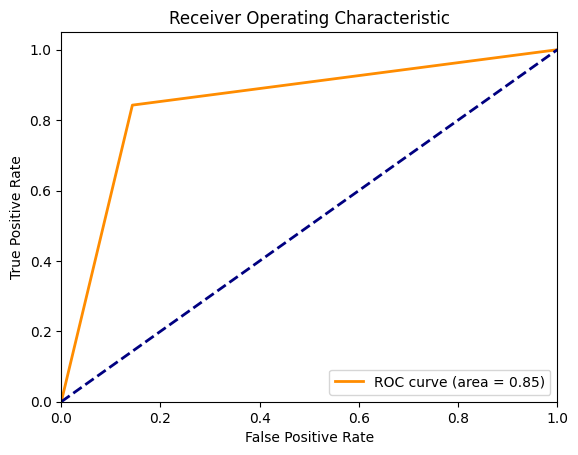

In [ ]:
X = df_final.drop('status', axis=1)  # Características
y = df_final['status']  # Variable objetivo
X_train_plus_val, X_test, y_train_plus_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_plus_val, y_train_plus_val, test_size=0.214285714, random_state=42)

# Guardar los conjuntos de datos de entrenamiento, validación y prueba en archivos CSV
train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.to_csv('train_data.csv', index=False)
val_data.to_csv('val_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

# Creación del modelo
rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Precision y Recall
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
print("\nPrecision:", precision)
print("Recall:", recall)

# Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Accuracy on Test Set: 0.8533100029163021

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1697
           1       0.85      0.86      0.85      1732

    accuracy                           0.85      3429
   macro avg       0.85      0.85      0.85      3429
weighted avg       0.85      0.85      0.85      3429

Confusion Matrix on Test Set:
[[1445  252]
 [ 251 1481]]

Precision: 0.8545874206578188
Recall: 0.855080831408776


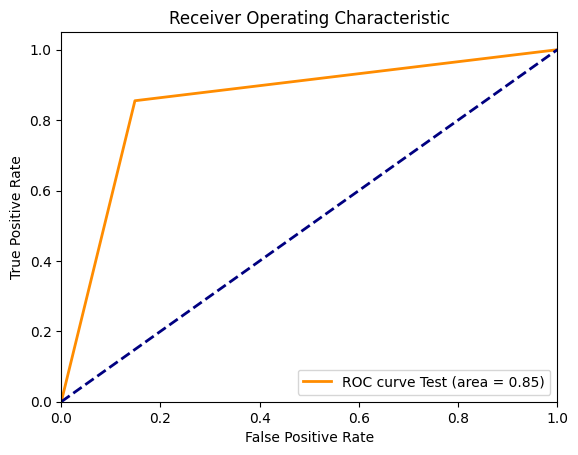

In [ ]:
y_pred_test = rf_model.predict(X_test)

print("\nAccuracy on Test Set:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_test))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix on Test Set:")
print(conf_matrix)

# Precision y Recall
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
print("\nPrecision:", precision)
print("Recall:", recall)

# Curva ROC y AUC
fpr_t, tpr_t, thresholds_t = roc_curve(y_test, y_pred_test)
roc_auc_t = auc(fpr_t, tpr_t)

plt.figure()
lw = 2
plt.plot(fpr_t, tpr_t, color='darkorange', lw=lw, label='ROC curve Test (area = %0.2f)' % roc_auc_t)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Resultados del primer modelo

Los resultados del modelo muestran un rendimiento bastante sólido en la clasificación de sitios web como phishing o legítimos. El accuracy general es del 85.0%, lo que indica que el modelo clasifica correctamente el 85.0% de las instancias en el conjunto de prueba. El precision, recall y f1-score para ambas clases (phishing y legítimo) son similares y están alrededor del 85%, lo que sugiere un equilibrio entre la capacidad del modelo para predecir correctamente ambas clases. La matriz de confusión muestra que el modelo tiende a cometer errores de clasificación de manera equitativa entre ambas clases, con un número similar de falsos positivos y falsos negativos. En resumen, el modelo de clasificación de Random Forest parece tener un buen desempeño general en la detección de sitios web de phishing, aunque aún puede haber margen para mejorar la precisión en algunos casos específicos. También es posible anotar que las curvas ROC son idénticas, esto es así a simple vista porque la variación de los diferentes sets de prueba es mínima en cuanto a decimales, sin embargo las dos pruebas resultaron con resultados positivos.

### Modelo 2

Accuracy: 0.7743440233236152

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.69      0.75       851
           1       0.74      0.86      0.79       864

    accuracy                           0.77      1715
   macro avg       0.78      0.77      0.77      1715
weighted avg       0.78      0.77      0.77      1715

Confusion Matrix:
[[583 268]
 [119 745]]

Precision: 0.7354392892398816
Recall: 0.8622685185185185


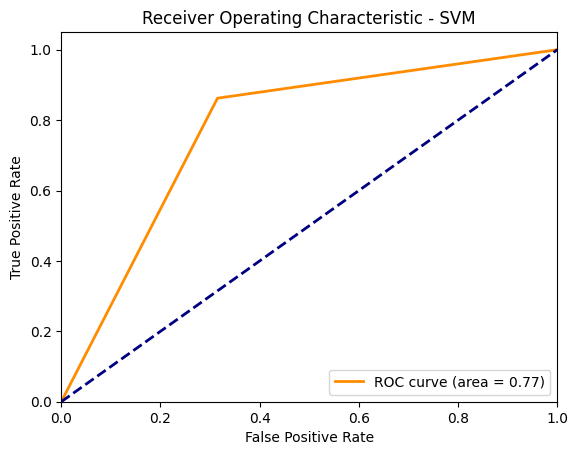

In [ ]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_val)

# Evaluamos el modelo
print("Accuracy:", accuracy_score(y_val, y_pred_svm))
print("\nClassification Report:")
print(classification_report(y_val, y_pred_svm))

# Matriz de confusión
conf_matrix_svm = confusion_matrix(y_val, y_pred_svm)
print("Confusion Matrix:")
print(conf_matrix_svm)

# Precision y Recall
precision_svm = conf_matrix_svm[1, 1] / (conf_matrix_svm[1, 1] + conf_matrix_svm[0, 1])
recall_svm = conf_matrix_svm[1, 1] / (conf_matrix_svm[1, 1] + conf_matrix_svm[1, 0])
print("\nPrecision:", precision_svm)
print("Recall:", recall_svm)

# Curva ROC y AUC
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_val, y_pred_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure()
lw = 2
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - SVM')
plt.legend(loc="lower right")
plt.show()


Accuracy on Test Set: 0.7821522309711286

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      1697
           1       0.75      0.86      0.80      1732

    accuracy                           0.78      3429
   macro avg       0.79      0.78      0.78      3429
weighted avg       0.79      0.78      0.78      3429

Confusion Matrix on Test Set:
[[1186  511]
 [ 236 1496]]

Precision: 0.7453911310413552
Recall: 0.8637413394919169


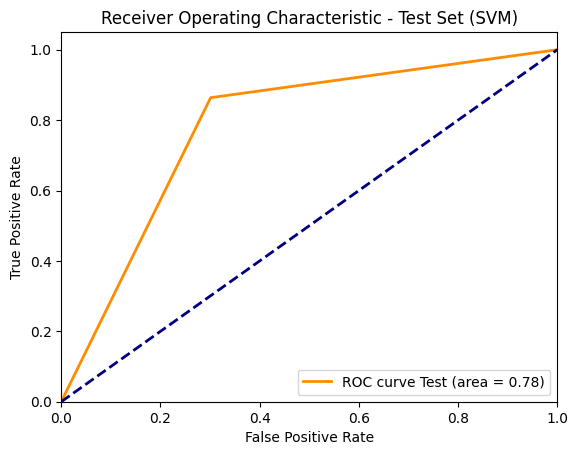

In [ ]:
y_pred_test_svm = svm_model.predict(X_test)

print("\nAccuracy on Test Set:", accuracy_score(y_test, y_pred_test_svm))
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_test_svm))

# Matriz de confusión
conf_matrix_test_svm = confusion_matrix(y_test, y_pred_test_svm)
print("Confusion Matrix on Test Set:")
print(conf_matrix_test_svm)

# Precision y Recall
precision_test_svm = conf_matrix_test_svm[1, 1] / (conf_matrix_test_svm[1, 1] + conf_matrix_test_svm[0, 1])
recall_test_svm = conf_matrix_test_svm[1, 1] / (conf_matrix_test_svm[1, 1] + conf_matrix_test_svm[1, 0])
print("\nPrecision:", precision_test_svm)
print("Recall:", recall_test_svm)

# Curva ROC y AUC
fpr_test_svm, tpr_test_svm, thresholds_test_svm = roc_curve(y_test, y_pred_test_svm)
roc_auc_test_svm = auc(fpr_test_svm, tpr_test_svm)

plt.figure()
lw = 2
plt.plot(fpr_test_svm, tpr_test_svm, color='darkorange', lw=lw, label='ROC curve Test (area = %0.2f)' % roc_auc_test_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test Set (SVM)')
plt.legend(loc="lower right")
plt.show()

### Resultado segundo modelo

El modelo SVM mostró un buen desempeño al clasificar URLs como maliciosas o normales, logrando una precisión general del 78.22%. Es destacable su habilidad para identificar la mayoría de las URLs maliciosas (86% de recall), aunque con alguna pérdida en la identificación de URLs normales (70% de recall). Aunque el modelo equilibra razonablemente precisión y recall, podría beneficiarse de ajustes adicionales para mejorar la identificación de URLs normales sin sacrificar la precisión en la detección de URLs maliciosas.

### Preguntas finales

- ¿Cuál es el impacto de clasificar un sitio legítimo como phishing?
    - Clasificar un sitio legítimo como phishing puede tener el impacto de generar molestias y frustración entre los usuarios legítimos, quienes podrían enfrentar bloqueos o restricciones de acceso a servicios válidos. Además, esto podría afectar la credibilidad y reputación de la empresa u organización detrás del sitio legítimo, socavando la confianza de los usuarios y las relaciones comerciales. Desde una perspectiva de seguridad, al cometer este error, los usuarios podrían ser desviados hacia sitios de phishing, exponiéndolos a riesgos de seguridad como el robo de datos personales o financieros.

- ¿Cuál es el impacto de clasificar un sitio de phishing como legítimo?
    - Acá ya se afecta directamente la seguridad del usuario. Esto puede llevar a que los usuarios confíen en un sitio malicioso y proporcionen información personal o financiera sensible, lo que resulta en el robo de identidad, fraude financiero u otras formas de explotación. Además, esto podría socavar los esfuerzos de seguridad de una organización al permitir que los atacantes continúen sus actividades fraudulentas sin ser detectados, lo que puede tener consecuencias graves para la integridad y reputación de la empresa afectada.

- En base a las respuestas anteriores, ¿Qué métrica elegiría para comparar modelos similares de clasificación de phishing?
    - Para comparar modelos similares de clasificación de phishing, una métrica importante sería el recall, especialmente en la clase de phishing (clase positiva). Dado que clasificar un sitio legítimo como phishing puede tener consecuencias graves en términos de seguridad para los usuarios, es crucial minimizar los falsos negativos (sitios de phishing que son clasificados incorrectamente como legítimos). Un alto recall en la clase de phishing indicaría que el modelo es efectivo para identificar la mayoría de los sitios de phishing, lo que ayuda a reducir el riesgo para los usuarios. Sin embargo, también sería importante considerar otras métricas como la precisión y el F1-score para obtener una evaluación completa del rendimiento del modelo en términos de balance entre la precisión y el recall.

- ¿Qué modelo funcionó mejor para la clasificación de phishing? ¿Por qué?
    - Al comparar el rendimiento de dos modelos para la clasificación de phishing, el modelo SVM y el modelo Random Forest, encontramos diferencias significativas en su capacidad para discernir entre URLs maliciosas y normales. El modelo SVM demostró una precisión general del 78.22%, con un recall del 86% para URLs maliciosas y un 70% para URLs normales. Por otro lado, el modelo Random Forest exhibió una precisión general del 85.0%, manteniendo un equilibrio entre precision y recall para ambas clases. Ambos modelos utilizaron características similares, como la longitud de la URL, conteo de subdominios, presencia de caracteres especiales, entre otras, para realizar la clasificación. Sin embargo, la diferencia clave radica en cómo cada modelo maneja la complejidad de estas características. El modelo Random Forest parece haber aprovechado mejor la relación entre las características para proporcionar una clasificación más precisa y equilibrada, lo que resultó en un mejor rendimiento general en comparación con el modelo SVM. Esto sugiere que el enfoque de aprendizaje conjunto y la capacidad de ensemble del modelo Random Forest fueron más efectivos para capturar las sutilezas de las características y realizar una clasificación más precisa en este contexto específico de detección de phishing.

- Una empresa desea utilizar su mejor modelo, debido a que sus empleados sufren constantes ataques de phishing mediante e-mail. La empresa estima que, de un total de 50,000 emails, un 15% son phishing. ¿Qué cantidad de alarmas generaría su modelo? ¿Cuántas positivas y cuantas negativas? ¿Funciona el modelo para el BR propuesto? En caso negativo, ¿qué se podría hacer para reducir la cantidad de falsas alarmas?
    - Para ayudar a la empresa a gestionar los constantes ataques de phishing por correo electrónico, el modelo predictivo puede estimar la cantidad de alarmas que generaría al examinar los 50,000 correos electrónicos, de los cuales se estima que el 15% son phishing (que sería 7,500 correos). Si consideramos el desempeño del modelo, que muestra un buen balance entre sensibilidad (recall) y precisión, es probable que identifique correctamente una gran parte de los correos phishing, minimizando así la cantidad de correos maliciosos no detectados. Sin embargo, también es crucial evaluar si el modelo genera un número aceptable de falsas alarmas. Si el modelo produce demasiadas falsas alarmas, podrían explorarse ajustes en el umbral de clasificación o mejoras en la ingeniería de características para reducir este número. En caso contrario, el modelo podría generar una cantidad considerable de alarmas innecesarias, lo que podría afectar negativamente la productividad de los empleados y aumentar el riesgo de pasar por alto correos electrónicos legítimos.

### Conclusiones

1) Importancia de las características y modelos adecuados: La selección y el diseño de características relevantes son fundamentales para el rendimiento efectivo de los modelos de detección de phishing. Características como la longitud de la URL, la presencia de subdominios, la cantidad de caracteres especiales y la edad del dominio pueden proporcionar señales importantes para la detección de sitios web maliciosos. Además, la elección del modelo de aprendizaje automático adecuado, como Random Forest o SVM, puede influir significativamente en el rendimiento general del sistema de detección.

2) Balance entre precisión y recall: Al evaluar el rendimiento de los modelos de detección de phishing, es crucial encontrar un equilibrio entre la precisión (capacidad para predecir correctamente sitios web maliciosos) y el recall (capacidad para identificar la mayoría de los sitios web maliciosos presentes). A menudo, los modelos muestran un trade-off entre estas métricas, y la elección del modelo final debe considerar las necesidades específicas del escenario de aplicación, como la tolerancia a las falsas alarmas y la priorización de la detección de phishing sobre la precisión en la clasificación de sitios legítimos.

3) Continua mejora y ajuste del modelo: La detección efectiva de phishing es un desafío en constante evolución debido a las tácticas cambiantes de los actores malintencionados. Por lo tanto, es crucial mantener un enfoque de mejora continua en el modelo de detección, que incluya la incorporación de nuevas características relevantes, la exploración de modelos más avanzados y la adaptación a las tendencias emergentes en las tácticas de phishing. Además, la evaluación regular del rendimiento del modelo en datos actualizados es esencial para garantizar su efectividad a largo plazo en la protección contra ataques de phishing.